In [ ]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install torch_audiomentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [4]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:
# other dependencies
#!pip install timm ipywidgets

In [6]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [8]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [9]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [10]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [11]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [12]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = True
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [13]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [14]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [15]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [16]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(
    transforms=[AddColoredNoise(p = 1)  ])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [17]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [ ]:
errors = []
for i, val in enumerate(y_test_B.squeeze()):
    if val != np.argmax(y_preds_all[0],-1)[i]:
        errors.append(i)

In [18]:
def test_model(epoch,model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    error_dict = {}
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [19]:
# #(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
# def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
#     # Creates a GradScaler once at the beginning of training.
#     loss_scaler = NativeScaler()
#     global_step = 0
#     torch.manual_seed(0)

#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     print(f'Training on {device}')    
    
#     if torch.cuda.device_count() > 1:
#         print("Using data parallel")
#         model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

#     model = model.to(device)
#     weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
#     criterion = nn.CrossEntropyLoss(weight=weights_adj)
#     optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
#     num_epochs = num_epochs
#     all_train_loss = []
#     all_train_acc = []
#     all_val_loss = []
#     all_val_acc = []
#     best_val_loss = np.inf
#     best_val_acc = -np.inf
#     best_train_acc = -np.inf
#     best_epoch = -1
#     checkpoint_name = None
#     overrun_counter = 0
#     sigmoid = nn.Sigmoid()
#     lr_log = []
#     for e in range(num_epochs):
#         start_time = time.time()
#         train_loss = 0.0
#         model.train()
#         running_loss = 0.0
#         all_y = []
#         all_y_pred = []
#         tk0 = tqdm(train_loader, total=int(len(train_loader)))
#         for batch_i, inputs in enumerate(tk0):
#             if DEBUG:
#                 print("inside train loop.. batch_ind = " +str(batch_i))
#             if batch_i % 200 == 0:
#                 bat_time = time.time()
#                 durn = (bat_time - start_time)/60
#                 print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
#             x = inputs[0].to(device).float()
#             y = inputs[1].type(torch.LongTensor).to(device)
#             global_step += 1
#             optimiser.zero_grad()
#             # AMP
#             with autocast():
#                 y_pred = model(x)['prediction']
#                 preds = torch.argmax(y_pred, axis = 1)
#                 if DEBUG:
#                     print("y_pred  = " +str(y_pred))
#                     print("preds = " +str(preds))
#                 loss = criterion(y_pred, y)
#             loss_scaler(loss, optimiser,parameters=model_parameters(model))
#             train_loss += loss.item()
#             all_y.append(y.cpu().detach())
#             y_pred_cpu = y_pred.cpu().detach()
#             preds = torch.argmax(y_pred_cpu, axis = 1)
#             if DEBUG:
#                 print("batch_ind = " +str(batch_i))
#                 print("y_pred_cpu = " + str(y_pred_cpu))
                
#             all_y_pred.append(preds.cpu().detach())
#             lr_log.append(optimiser.param_groups[0]['lr'])
#             tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
#             del x
#             del y
#             del y_pred,preds
        
#         all_train_loss.append(train_loss/len(train_loader))
#         all_y = torch.cat(all_y)
#         all_y_pred = torch.cat(all_y_pred)
#         if DEBUG:
#             print("y = " + str(all_y))
#             print("y_pred  = " + str(all_y_pred))
        
#         train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
#         if DEBUG:
#             print("train acc = " +str(train_acc))
#         all_train_acc.append(train_acc)
#         val_loss, val_acc , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
#         if DEBUG:
#             print("val accuracy = " + str(val_acc))
#         all_val_loss.append(val_loss)
#         all_val_acc.append(val_acc)
        
#         acc_metric = val_acc
#         best_acc_metric = best_val_acc
#         if acc_metric > best_acc_metric:  
#             checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
#             torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
#             print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
#             print("Now printing classification rport... ")
#             from sklearn.metrics import classification_report
#             _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
#             print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
#             plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
#             best_epoch = e
#             best_val_acc = val_acc
#             best_val_loss = val_loss
#             overrun_counter = -1
#         overrun_counter += 1
#         print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
#         if overrun_counter > config_pytorch.max_overrun:
#             break
            
    
#     return model, lr_log

In [20]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(
    transforms=[AddColoredNoise(p = 1)  ])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [21]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=apply_augmentation):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        if idx%2 == 0:
            if DEBUG:
                print("shape of x = " + str(x.shape))
                print("applying augmentations...")
            #augmentation expect input in the form of [bat,chann,sample]
            x_unsq = x.unsqueeze(dim = 1)
            if DEBUG:
                print("shape of x_unsq = " + str(x_unsq.shape))
            x = apply_augmentation(x_unsq, sample_rate=config.rate)
            x = x.squeeze(dim = 1)
            if DEBUG:
                print("shape of x post augmentation = " + str(x.shape))
            
                       
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [22]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [23]:
def apply_aug(x,rate):
        apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])
        aug_audio = apply_augmentation(x,sample_rate = rate)
        return(aug_audio)
    

class augment_audio(nn.Module):
    def __init__(self , trainable = True, sample_rate = config.rate):
        super().__init__()
        self.trainable = trainable
        self.rate = sample_rate
            
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
           
        if self.trainable:
            x = apply_aug(x , self.rate)
        else:
            x = x
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x.squeeze(dim = 1)

In [24]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.augment_layer(x)
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [ ]:
import torch
test = torch.rand(64,15360)
model =Model('convnext_small',224)
op = model(test)
print(op)

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1328 seconds


In [56]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [57]:
df_train_offset

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2
...,...,...,...,...,...
103840,103840,220776,174081,25.540000,6
103841,103841,220776,176641,25.540000,6
103842,103842,220776,179201,25.540000,6
103843,103843,220776,181761,25.540000,6


In [58]:
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = apply_augmentation)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [59]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 103845
Length of train loader = 812


In [60]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [61]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [62]:
len(df_train_offset)

103845

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1085 seconds
Training on cuda:0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 0batch = 0 of 812duraation = 0.06569900512695312
epoch = 0batch = 200 of 812duraation = 3.7667155782381694
epoch = 0batch = 400 of 812duraation = 7.481128470102946
epoch = 0batch = 600 of 812duraation = 11.03522257010142
epoch = 0batch = 800 of 812duraation = 14.574993701775869
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_18_00_47_15.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.70      0.26      0.38      9018
culex pipiens complex       0.47      0.35      0.40      4157
           ae aegypti       0.08      0.68      0.14       429
       an funestus ss       0.32      0.42      0.36      3422
         an squamosus       0.13      0.34      0.19      1327
          an coustani       0.16      0.47      0.24       657
         ma uniformis       0.19      0.12      0.14       975
         ma africanus       0.03      0.15      0.05       423
               others       0.0

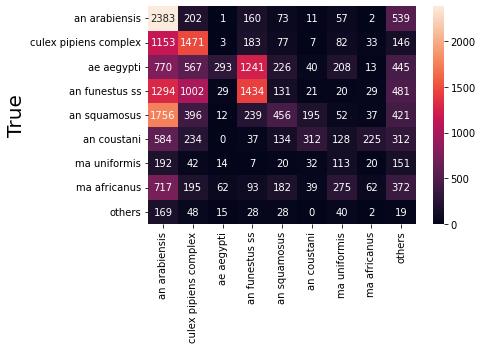

Epoch: 0, Train Loss: 1.77765908, Train Acc: 0.35836102, Val Loss: 0.00743382, Val Acc: 0.50423540, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 1batch = 0 of 812duraation = 0.06645955244700114
epoch = 1batch = 200 of 812duraation = 3.62447141011556
epoch = 1batch = 400 of 812duraation = 7.173304716746013
epoch = 1batch = 600 of 812duraation = 10.732544382413229
epoch = 1batch = 800 of 812duraation = 14.26173419157664
Saving model to: ../outputs/models/pytorch/model_e1_2022_09_18_01_07_44.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.44      0.51      9018
culex pipiens complex       0.50      0.40      0.44      4157
           ae aegypti       0.07      0.61      0.13       429
       an funestus ss       0.42      0.38      0.40      3422
         an squamosus       0.17      0.35      0.23      1327
          an coustani       0.19      0.41      0.26       657
         ma uniformis       0.18      0.30      0.22       975
         ma africanus       0.05      0.09      0.07       423
               others       0.05 

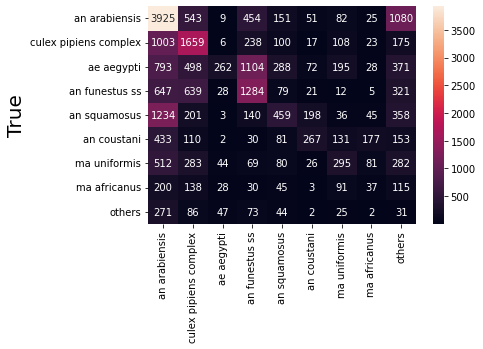

Epoch: 1, Train Loss: 1.22959995, Train Acc: 0.55767731, Val Loss: 0.00684885, Val Acc: 0.55599238, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 2batch = 0 of 812duraation = 0.06935559511184693
epoch = 2batch = 200 of 812duraation = 3.6454326152801513
epoch = 2batch = 400 of 812duraation = 7.151509575049082
epoch = 2batch = 600 of 812duraation = 10.700122853120169
epoch = 2batch = 800 of 812duraation = 14.21408684651057
Saving model to: ../outputs/models/pytorch/model_e2_2022_09_18_01_28_09.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.44      0.51      9018
culex pipiens complex       0.52      0.41      0.46      4157
           ae aegypti       0.14      0.48      0.22       429
       an funestus ss       0.41      0.55      0.47      3422
         an squamosus       0.18      0.45      0.25      1327
          an coustani       0.16      0.33      0.21       657
         ma uniformis       0.19      0.26      0.22       975
         ma africanus       0.06      0.20      0.10       423
               others       0.1

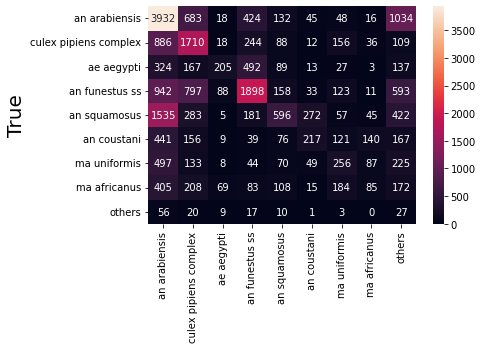

Epoch: 2, Train Loss: 1.04714360, Train Acc: 0.60646155, Val Loss: 0.00653385, Val Acc: 0.58452559, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 3batch = 0 of 812duraation = 0.06984884738922119
epoch = 3batch = 200 of 812duraation = 3.6326574246088663
epoch = 3batch = 400 of 812duraation = 7.1689403812090555
epoch = 3batch = 600 of 812duraation = 10.702271099885305
epoch = 3batch = 800 of 812duraation = 14.221355100472769
Saving model to: ../outputs/models/pytorch/model_e3_2022_09_18_01_48_33.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.43      0.51      9018
culex pipiens complex       0.42      0.51      0.46      4157
           ae aegypti       0.09      0.29      0.14       429
       an funestus ss       0.45      0.55      0.50      3422
         an squamosus       0.21      0.36      0.27      1327
          an coustani       0.19      0.34      0.25       657
         ma uniformis       0.16      0.26      0.20       975
         ma africanus       0.04      0.11      0.06       423
               others       0

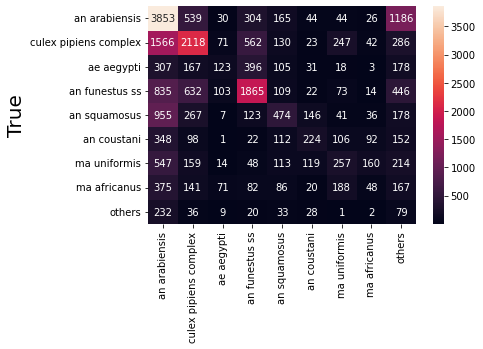

Epoch: 3, Train Loss: 0.89843598, Train Acc: 0.65108575, Val Loss: 0.00632236, Val Acc: 0.60701982, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 4batch = 0 of 812duraation = 0.06619521379470825
epoch = 4batch = 200 of 812duraation = 3.6381330569585164
epoch = 4batch = 400 of 812duraation = 7.149329884847005
epoch = 4batch = 600 of 812duraation = 10.6596950729688
epoch = 4batch = 800 of 812duraation = 14.225868479410808
Saving model to: ../outputs/models/pytorch/model_e4_2022_09_18_02_08_59.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.45      0.52      9018
culex pipiens complex       0.44      0.53      0.48      4157
           ae aegypti       0.13      0.47      0.21       429
       an funestus ss       0.44      0.57      0.50      3422
         an squamosus       0.22      0.42      0.28      1327
          an coustani       0.20      0.30      0.24       657
         ma uniformis       0.20      0.29      0.24       975
         ma africanus       0.07      0.09      0.08       423
               others       0.50

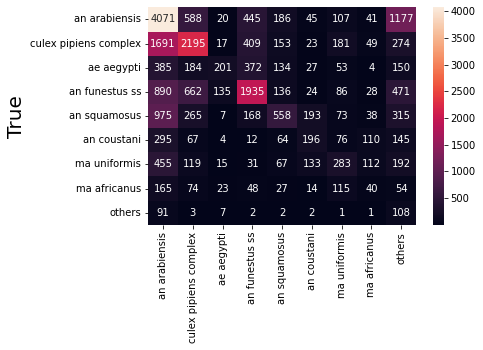

Epoch: 4, Train Loss: 0.79509212, Train Acc: 0.68261351, Val Loss: 0.00663694, Val Acc: 0.62059741, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 5batch = 0 of 812duraation = 0.06208314895629883


In [ ]:
model =Model('convnext_small',224)

model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))